# Deep Learning with `Flux.jl`
---

The purpose of this notebook is to showcase one of the most popular deep learning framework in Julia: `Flux.jl`.
   
   
*References for this notebook:*
*  Flux Neural Network tutorial: [Deep Learning with Julia](https://medium.com/coffee-in-a-klein-bottle/deep-learning-with-julia-e7f15ad5080b)

## Outline of this notebook


- Generate data 
- Create the Neural Network 
- Train the model
- Visualize Results

## Libraries

In [2]:
# Packages
using Plots
using Statistics
using Flux

In [2]:
# External source
include("notebookFormatting.jl");

## Generate data 

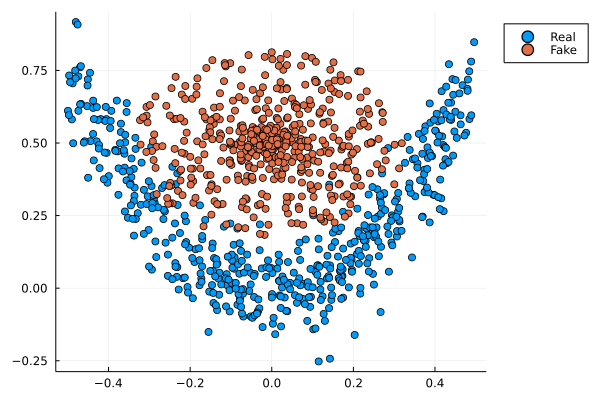

In [4]:
#Auxiliary functions for generating our data
function generate_real_data(n)
    x1 = rand(1,n) .- 0.5
    x2 = (x1 .* x1)*3 .+ randn(1,n)*0.1
    return vcat(x1,x2)
end
function generate_fake_data(n)
    θ  = 2*π*rand(1,n)
    r  = rand(1,n)/3
    x1 = @. r*cos(θ)
    x2 = @. r*sin(θ)+0.5
    return vcat(x1,x2)
end
# Creating our data
train_size = 5000
real = generate_real_data(train_size)
fake = generate_fake_data(train_size)
# Visualizing
scatter(real[1,1:500],real[2,1:500], label = "Real")
scatter!(fake[1,1:500],fake[2,1:500], 
         legend = :outertopright, label = "Fake")

## Creating the Neural Network

In [5]:
function NeuralNetwork()
    return Chain(
            # layer 1: 2 inputs, 25 outputs, 
            #          activation function: relu(Rectified Linear Unit function f(x) = max(0, x))
            Dense(2, 25,relu),
            # layer 2: 25 inputs, 1 output, 
            #          activation function: sigmoid function (f(x)= (1+e⁻ˣ)⁻¹)
            Dense(25,1,x->σ.(x))
            )
end

NeuralNetwork (generic function with 1 method)

## Train model

In [8]:
# Organizing the data in batches
X    = hcat(real,fake)
Y    = vcat(ones(train_size),zeros(train_size));

In [9]:
# Create batches by generating an object that iterates over mini-batches of data, 
# each mini-batch containing batchsize observations 
# (except possibly the last one).
data = Flux.Data.DataLoader((X, Y'), batchsize=100,shuffle=true);

In [10]:
# Define our model
m = NeuralNetwork()
# Define optimization algorithm
# Gradient descent with a learning η = 0.05
lr = 0.05
opt  = Descent(lr) 
# Define loss function
loss(x, y) = sum(Flux.Losses.binarycrossentropy(m(x), y)) # m(x), predicted values;

### Training Method 1

Declare what parameters are going to be trained:

In [11]:
# we can select what specific layers need to be trained, useful for transfer learning.
ps = Flux.params(m);

Define how many epochs will be used:    

In [12]:
# hyperparameter that defines the number of times that a learning algorithm will handle the entire training data set.
numEpochs = 20;

Training:

In [13]:
for i in 1:numEpochs
    Flux.train!(loss, ps, data, opt)
end

In [19]:
outputModel = [mean(m(real)) mean(m(fake))]
println(round.(outputModel; digits = 4)) # Print model prediction

[0.8097 0.1848]


### Training Method 2

In [20]:
m2    = NeuralNetwork()
epochs = 20
loss2(x, y) = sum(Flux.Losses.binarycrossentropy(m2(x), y)) # m(x), predicted values
for epoch = 1:epochs
    for batch in data
        # compute gradient according to parameters values and 
        # apply results to the loss function for the batch d
        gs = Flux.gradient(Flux.params(m2)) do
            l = loss2(batch...)
        end
        # update the new parameters values according the gradients from 
        # the last iteration.
        Flux.Optimise.update!(opt, Flux.params(m2), gs)
    end
end

outputModel = [mean(m2(real)) mean(m2(fake))]
println(round.(outputModel; digits = 4)) # Print model prediction


[0.8099 0.1931]


In [98]:
fieldnames(typeof(data))

(:data, :batchsize, :nobs, :partial, :imax, :indices, :shuffle, :rng)

## Results Visualization

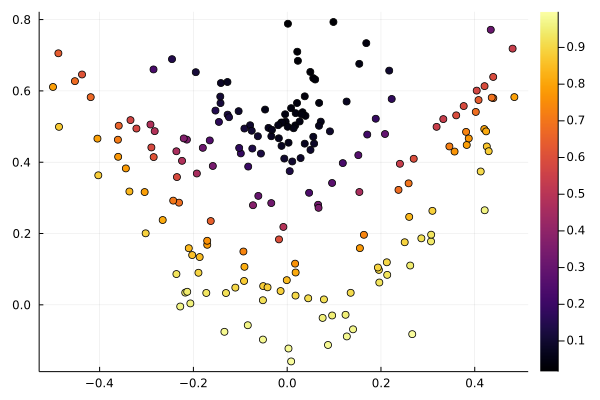

In [24]:
scatter(real[1,1:100],real[2,1:100],zcolor=m(real)')
scatter!(fake[1,1:100],fake[2,1:100],zcolor=m(fake)',legend=false)

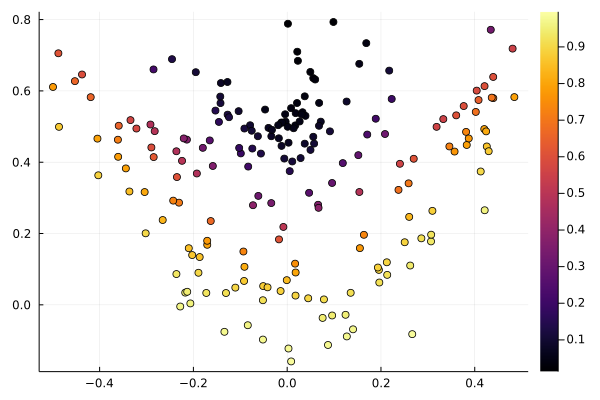

In [25]:
scatter(real[1,1:100],real[2,1:100],zcolor=m2(real)')
scatter!(fake[1,1:100],fake[2,1:100],zcolor=m2(fake)',legend=false)